# Instrument Parameter Sensitivity Studies

## Investigating the effect of alternate instrument FWHM



In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
using LaTeXStrings
set_theme!(theme_ggplot2())

  Activating project at `~/repos/CarbonI`


In [9]:
function create_simple_conv_matrix(modelling_wl::StepRangeLen{FT}, instrument_wl; FWHM::Float64=2.2, verbose_return::Bool=false) where FT
    # Define a Fixed instrument:
    Δwl = modelling_wl.step.hi
    
    kern = CarbonI.gaussian_kernel(FWHM, Δwl)
    
    #Get the Instrument-specific box
    lociBox = CarbonI.KernelInstrument(kern, instrument_wl);

    # Generate final convolution matrix:
    cM = CarbonI.generate_conv_matrix(lociBox,modelling_wl, Δwl)
    if verbose_return
        return cM, lociBox.ν_out, lociBox
    else
        return cM, lociBox.ν_out
    end
end

create_simple_conv_matrix (generic function with 1 method)

In [2]:
# Define numbers from L1 Requirements - this part duplicates Level1-Req-1.ipynb

# Flux limits:
flux_detect_ch4_req = 175.0u"kg/hr"    # in kg CH4/hr
flux_detect_co2_req = 100e3u"kg/hr"    # in kg CO2/hr
flux_detect_co_req  = 1.75e3u"kg/hr"   # in kg CO/hr

# GSD, required and CBE
gsd_req  = [400.0u"m", 400.0u"m"]      # in m
gsd_cbe  = [303.0u"m", 345.0u"m"]      # in m

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 303.0 m
 345.0 m

In [3]:
# Effective Pixel Sizes
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m² mol⁻¹


2.841957e-6 m² mol⁻¹

In [5]:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

@show uconvert(u"ppb", σ_ch4_req)
@show uconvert(u"ppm", σ_co2_req)
@show uconvert(u"ppb", σ_co_req)

@printf("Required Single Measurement Precision for CH₄ : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_ch4_req)))
@printf("Required Single Measurement Precision for CO₂ : %.3g ppm\n",  ustrip(uconvert(u"ppm", σ_co2_req)))
@printf("Required Single Measurement Precision for CO  : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_co_req)))

uconvert(u"ppb", σ_ch4_req) = 5.383053596477556 ppb
uconvert(u"ppm", σ_co2_req) = 1.1210981879118382 ppm
uconvert(u"ppb", σ_co_req) = 30.82619767493752 ppb
Required Single Measurement Precision for CH₄ : 5.38 ppb
Required Single Measurement Precision for CO₂ : 1.12 ppm
Required Single Measurement Precision for CO  : 30.8 ppb


In [23]:
# Use the reference scenario
scenario = CarbonI.reference_scenario();


# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Define new conv matrix - probably need to build a new wl grid for each?
cM_cbe, _, kernel_cbe = create_simple_conv_matrix(cbe_specs.modelling_wl, cbe_specs.instrument_wl; FWHM=2.2, verbose_return=true);
cbe_specs.convolution_matrix = cM_cbe;
cbe_specs.instrument_kernel = kernel_cbe;

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");
cM_req, _, kernel_req = create_simple_conv_matrix(req_specs.modelling_wl, req_specs.instrument_wl; FWHM=2.2, verbose_return=true);
req_specs.convolution_matrix = cM_req;
req_specs.instrument_kernel = kernel_req;


(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [24]:
# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [30]:
# Get reflectance here
wll = req_specs.modelling_wl;
refl_req   = scenario.surface_albedo(wll);
refl_cbe   = scenario.surface_albedo(wll);

In [43]:
F_req = forward_model_x_(x_req, 
                        sun=solarIrr_req, 
                        instrument=req_specs.instrument_kernel, 
                        reflectance=refl_req, 
                        sza=scenario.sza, 
                        σ_matrix=σ_matrix_req, 
                        profile=profile_req, 
                        wl=req_specs.modelling_wl);

F_cbe = forward_model_x_(x_cbe, 
                        sun=solarIrr_cbe, 
                        instrument=cbe_specs.instrument_kernel, 
                        reflectance=refl_cbe, 
                        sza=scenario.sza, 
                        σ_matrix=σ_matrix_cbe, 
                        profile=profile_cbe, 
                        wl=req_specs.modelling_wl);

In [76]:
fwhms=[2.0,3.0,4.0,5.0,6.0,7.0,8.0]
f_reqs = []
for fwhm=fwhms
    # Define new conv matrix - probably need to build a new wl grid for each?
    req_specs = CarbonI.build_instrument("Requirement");
    cM_req, _, Ikernel_req = create_simple_conv_matrix(req_specs.modelling_wl, req_specs.instrument_wl; FWHM=fwhm, verbose_return=true);
    req_specs.convolution_matrix = cM_req;
    req_specs.instrument_kernel = Ikernel_req;

    # Create required Instrument model 
    ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		        req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		        req_specs.Fnumber, 2*req_specs.SSI, 
		        (req_specs.readout_noise), req_specs.dark_current); 

    F_req = forward_model_x_(x_req, 
                        sun=solarIrr_req, 
                        instrument=req_specs.instrument_kernel, 
                        reflectance=refl_req, 
                        sza=scenario.sza, 
                        σ_matrix=σ_matrix_req, 
                        profile=profile_req, 
                        wl=req_specs.modelling_wl);
    push!(f_reqs, F_req);
end

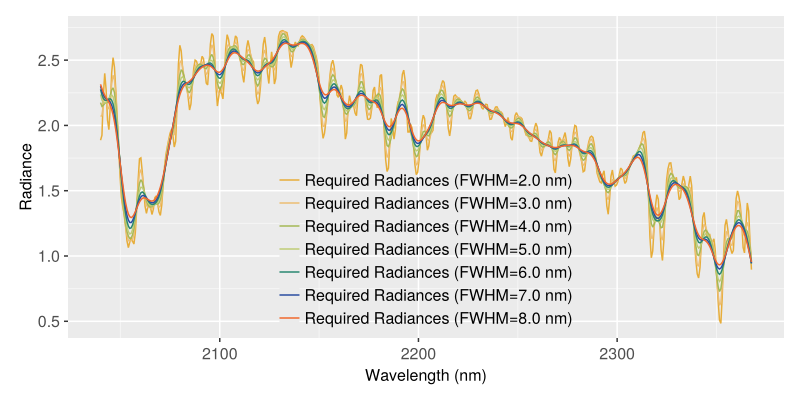

In [80]:
f = Figure(resolution=(800,400))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Radiance")
colors=[CarbonI_colors[ind] for ind=[1,6,2,7,3,4,5]]
for _fwhm=1:length(fwhms)
    fwhm=fwhms[_fwhm]
    lines!(req_specs.instrument_wl, f_reqs[_fwhm], color = colors[_fwhm], linewidth=1.5, label="Required Radiances (FWHM=$fwhm nm)")
end
axislegend(position = :cb)
f

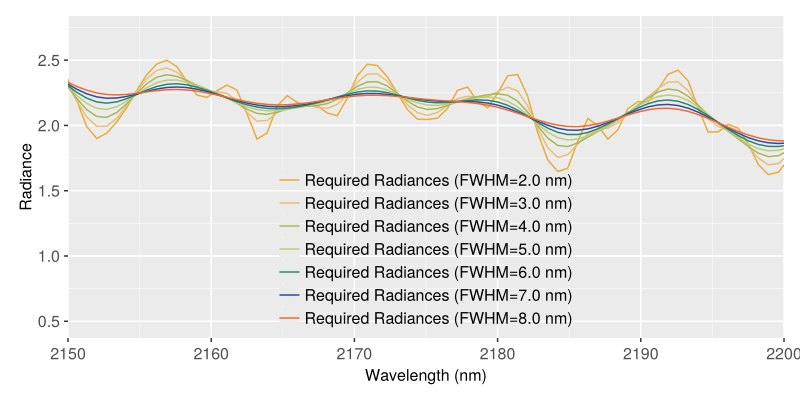

In [81]:
f = Figure(resolution=(800,400))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Radiance")
colors=[CarbonI_colors[ind] for ind=[1,6,2,7,3,4,5]]
for _fwhm=1:length(fwhms)
    fwhm=fwhms[_fwhm]
    lines!(req_specs.instrument_wl, f_reqs[_fwhm], color = colors[_fwhm], linewidth=1.5, label="Required Radiances (FWHM=$fwhm nm)")
end
xlims!(ax,2150, 2200)
axislegend(position = :cb)
f